 ### please re-start kernel if these packages are installed for the first time

In [1]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs --break-system-packages
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO --break-system-packages

In [2]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO

### This template is for
- objFuncs: v1.0.4  
- pyBO: v1.0.2

In [3]:
import objFuncs
from objFuncs import maximize_FC, construct_machineIO
from objFuncs.util import get_MEBT_objective_goal_from_BPMoverview
from objFuncs.preset import get_preset, get_tolerance, get_limits
from pyBO import pyBO

objFuncs version: 1.0.4. updated on 2024-03-26
pyBO version: 1.0.2. updated on 2024-03-26


In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import datetime
from phantasy import caget,fetch_data
import pandas as pd

# user inputs
### check and adjust decision (control knobs) and objectives later

In [5]:
is_close_to_opt = False     # True for local optimization. 
FC814 = 30                  # uA
timespan_for_average = 2.0  # sec  
additional_wait_after_powersupply_ramp  = 0.25 # sec

##== BPM_snapshot will just display objective goal template from snapshot
BPM_snapshot_fname = '20230527_1926_124Xe26_3q_216p5MeVu.bpm'  
# BPM_snapshot_fname = None

In [6]:
if is_close_to_opt:
    n_init_budget       = 6   # recommended: number of decision parameters 
    n_global_opt_budget = 0
    n_local_opt_budget  = 30
    n_finetune_budget   = 5   # recommended: less than number of decision parameters 
else:
    n_init_budget       = 30          
    n_global_opt_budget = 30
    n_local_opt_budget  = 30
    n_finetune_budget   = 5    # recommended: less than number of decision parameters 

budget = n_init_budget +n_global_opt_budget +n_local_opt_budget +n_finetune_budget
print(f"budget: {budget}")

budget: 95


# check machineIO, source and beam  

In [7]:
objFuncs._global_machineIO._test = False
objFuncs._global_machineIO._fetch_data_time_span = timespan_for_average
objFuncs._global_machineIO._ensure_set_timewait_after_ramp = additional_wait_after_powersupply_ramp

In [8]:
SCS = caget("ACS_DIAG:DEST:ACTIVE_ION_SOURCE")
ion = caget("FE_ISRC"+str(SCS)+":BEAM:ELMT_BOOK")
Q = caget("FE_ISRC"+str(SCS)+":BEAM:Q_BOOK")
A = caget("FE_ISRC"+str(SCS)+":BEAM:A_BOOK")
# AQ = caget("FE_ISRC2:BEAM:MOVRQ_BOOK")
AQ = A/Q
ion = str(A)+ion+str(Q)
print('SCS'+str(SCS), ion, 'A/Q=',AQ)

SCS2 48Ca10 A/Q= 4.8


In [9]:
now0 = datetime.datetime.now()
fname = now0.strftime('%Y%m%d_%H%M')+'['+ion+'][pyBO][MEBT]FC1102'
fname

'20240327_1529[48Ca10][pyBO][MEBT]FC1102'

# preprare decision ( control knob)

In [10]:
# preset = get_preset('[MEBT]FC1102',BPM_snapshot_fname=BPM_snapshot_fname)
# for k,v in preset.items():
#     if 'decision' in k:
#         print(f'==== {k} ====')
#         display(v)

to do list:
 - try a V-dipole instead of a V-corrector to avoid polarity crossing time
 - try solenoids 

In [11]:
decision_CSETs = [
#                  'FE_LEBT:PSC2_D0948:I_CSET', 'FE_LEBT:PSC1_D0948:I_CSET',
                 'FE_LEBT:PSC2_D0964:I_CSET', 'FE_LEBT:PSC1_D0964:I_CSET',
                 'FE_LEBT:PSC2_D0979:I_CSET', 'FE_LEBT:PSC1_D0979:I_CSET',
                 'FE_LEBT:PSC2_D0992:I_CSET', 'FE_LEBT:PSC1_D0992:I_CSET',
                  ]
ave, _ = fetch_data(decision_CSETs,0.01)

decision_tols = []
decision_min = []
decision_max = []
for v, PV in zip(ave,decision_CSETs):
    if 'PSC' in PV:
#         decision_min.append(v-0.7*AQ)
#         decision_max.append(v+0.7*AQ)
        decision_min.append( -0.8*AQ)
        decision_max.append( +0.8*AQ)
        decision_tols.append(0.2)
    elif 'PSOL' in PV:
        decision_min.append(0.9*v)
        decision_max.append(1.1*v)
        decision_tols.append(1.0)
    else:
        raise ValueError(f'decision bounds for {PV} cannot be determined')

##== Manually set decision bounds and tolerance
# decision_min = [ -5, -5, -5, -5, -5, -5]
# decision_max = [  5,  5,  5,  5,  5,  5]
# decision_tol = [0.2,0.2,0.2,0.2,0.2,0.2]
         
assert len(decision_CSETs) == len(decision_min) == len(decision_max) == len(decision_tols)
decision_Lo_limit, decision_Hi_limit = get_limits(decision_CSETs)
decision_min = np.clip(decision_min, a_min = decition_Lo_limit, a_max = None)
decision_max = np.clip(decision_max, a_min = None, a_max = decition_Hi_limit)
assert np.all(decision_max > decision_min)

pd.DataFrame(np.array([ave,decision_min,decision_max,decision_tols,decision_Lo_limit,decision_Hi_limit]).T,
             index=decision_CSETs, 
             columns=['current value','decision min','decision max','tol','LoLim','HiLim'])

,current value,decision min,decision max,tol,op_LoLim,op_HiLim
FE_LEBT:PSC2_D0964:I_CSET,0.148602,-3.84,3.84,0.2,-5.5,5.5
FE_LEBT:PSC1_D0964:I_CSET,-2.842004,-3.84,3.84,0.2,-5.5,5.5
FE_LEBT:PSC2_D0979:I_CSET,3.024544,-3.84,3.84,0.2,-5.5,5.5
FE_LEBT:PSC1_D0979:I_CSET,0.751783,-3.84,3.84,0.2,-5.5,5.5
FE_LEBT:PSC2_D0992:I_CSET,0.032265,-3.84,3.84,0.2,-5.5,5.5
FE_LEBT:PSC1_D0992:I_CSET,0.027470,-3.84,3.84,0.2,-5.5,5.5


# preprare objective function

In [12]:
if BPM_snapshot_fname is not None:
    display(get_MEBT_objective_goal_from_BPMoverview(BPM_snapshot_fname))

{'FE_MEBT:BPM_D1056:XPOS_RD': -0.345812289535008,
 'FE_MEBT:BPM_D1056:YPOS_RD': 0.2755291980547795,
 'FE_MEBT:BPM_D1056:PHASE_RD': 80.01379620843083,
 'FE_MEBT:BPM_D1072:XPOS_RD': 0.11800521457630664,
 'FE_MEBT:BPM_D1072:YPOS_RD': 0.4313544346071099,
 'FE_MEBT:BPM_D1072:PHASE_RD': -23.42850231099402,
 'FE_MEBT:BPM_D1094:XPOS_RD': 0.04434067124873937,
 'FE_MEBT:BPM_D1094:YPOS_RD': -0.15548171891011758,
 'FE_MEBT:BPM_D1094:PHASE_RD': -14.992799801690156}

In [13]:
objective_goal= {
    'FE_MEBT:BPM_D1056:XPOS_RD' : -0.345812289535008,
    'FE_MEBT:BPM_D1056:YPOS_RD' : 0.2755291980547795,
    'FE_MEBT:BPM_D1056:PHASE_RD': 80.01379620843083,
    'FE_MEBT:BPM_D1072:XPOS_RD' : 0.11800521457630664,
    'FE_MEBT:BPM_D1072:YPOS_RD' : 0.4313544346071099,
    'FE_MEBT:BPM_D1072:PHASE_RD': -23.42850231099402,
    'FE_MEBT:BPM_D1094:XPOS_RD' : 0.04434067124873937,
    'FE_MEBT:BPM_D1094:YPOS_RD' : -0.15548171891011758,
    'FE_MEBT:BPM_D1094:PHASE_RD': -14.992799801690156,
    'FE_MEBT:BCM_D1055:AVGPK_RD': {'more than': FC814},
    'FE_MEBT:FC_D1102:PKAVG_RD' : {'more than': 0.8*FC814},
}

In [14]:
objective_norm= {
    'FE_MEBT:BPM_D1056:XPOS_RD' : 1,
    'FE_MEBT:BPM_D1056:YPOS_RD' : 1,
    'FE_MEBT:BPM_D1056:PHASE_RD': 1,
    'FE_MEBT:BPM_D1072:XPOS_RD' : 1,
    'FE_MEBT:BPM_D1072:YPOS_RD' : 1,
    'FE_MEBT:BPM_D1072:PHASE_RD': 1,
    'FE_MEBT:BPM_D1094:XPOS_RD' : 1,
    'FE_MEBT:BPM_D1094:YPOS_RD' : 1,
    'FE_MEBT:BPM_D1094:PHASE_RD': 1,
    'FE_MEBT:BCM_D1055:AVGPK_RD': 0.05*FC814,
    'FE_MEBT:FC_D1102:PKAVG_RD' : 0.05*0.8*FC814,
}

In [15]:
##== If weight of any objective is zero, the corresponding objective will be removed.
objective_weight= {
    'FE_MEBT:BPM_D1056:XPOS_RD' : 0.8,
    'FE_MEBT:BPM_D1056:YPOS_RD' : 0.8,
    'FE_MEBT:BPM_D1056:PHASE_RD': 1,
    'FE_MEBT:BPM_D1072:XPOS_RD' : 0.4,
    'FE_MEBT:BPM_D1072:YPOS_RD' : 0.4,
    'FE_MEBT:BPM_D1072:PHASE_RD': 0.5,
    'FE_MEBT:BPM_D1094:XPOS_RD' : 0.2,
    'FE_MEBT:BPM_D1094:YPOS_RD' : 0.2,
    'FE_MEBT:BPM_D1094:PHASE_RD': 0.25,
    'FE_MEBT:BCM_D1055:AVGPK_RD': 2,
    'FE_MEBT:FC_D1102:PKAVG_RD' : 2,
}

In [16]:
obj = maximize_FC.maximize_FC1102(
    decision_CSETs=decision_CSETs,
    decision_min = decision_min,
    decision_max = decision_max,
    decision_tols = decision_tols,
    objective_goal = objective_goal,
    objective_weight = objective_weight,
    objective_norm = objective_norm,
    apply_bilog = True,
)

======== class info ========
init_time: 2024-03-27 15:11:43.389692
class_hierarchy: [
    maximize_FC1102, objFuncGoals, objFuncBase]
machineIO: <objFuncs.construct_machineIO.construct_machineIO object at 0x7fbf2f31f050>
decision_CSETs: [
    FE_LEBT:PSC2_D0964:I_CSET, FE_LEBT:PSC1_D0964:I_CSET, FE_LEBT:PSC2_D0979:I_CSET
    FE_LEBT:PSC1_D0979:I_CSET, FE_LEBT:PSC2_D0992:I_CSET, FE_LEBT:PSC1_D0992:I_CSET]
decision_min: [-3.69139811 -5.5        -0.81545606 -3.08821747 -3.80773539 -3.81253028]
decision_max: [3.98860189 0.99799641 5.5        4.59178253 3.87226461 3.86746972]
decision_bounds : array of shape (6, 2) and type float64
decision_RDs: [
    FE_LEBT:PSC2_D0964:I_RD, FE_LEBT:PSC1_D0964:I_RD, FE_LEBT:PSC2_D0979:I_RD
    FE_LEBT:PSC1_D0979:I_RD, FE_LEBT:PSC2_D0992:I_RD, FE_LEBT:PSC1_D0992:I_RD]
decision_tols: [0.2 0.2 0.2 0.2 0.2 0.2]
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_tag: FC1102
logging_fname: None
x0: [ 0.14860189 -2.84200359  3.02454

# run Optim

In [17]:
ctrBO = pyBO.bo_controller(obj,local_optimization = is_close_to_opt)

init will random sample within the following bounds:


,min,max
FE_LEBT:PSC2_D0964:I_CSET,-3.691398,3.988602
FE_LEBT:PSC1_D0964:I_CSET,-5.500000,0.997996
FE_LEBT:PSC2_D0979:I_CSET,-0.815456,5.500000
FE_LEBT:PSC1_D0979:I_CSET,-3.088217,4.591783
FE_LEBT:PSC2_D0992:I_CSET,-3.807735,3.872265
FE_LEBT:PSC1_D0992:I_CSET,-3.812530,3.867470


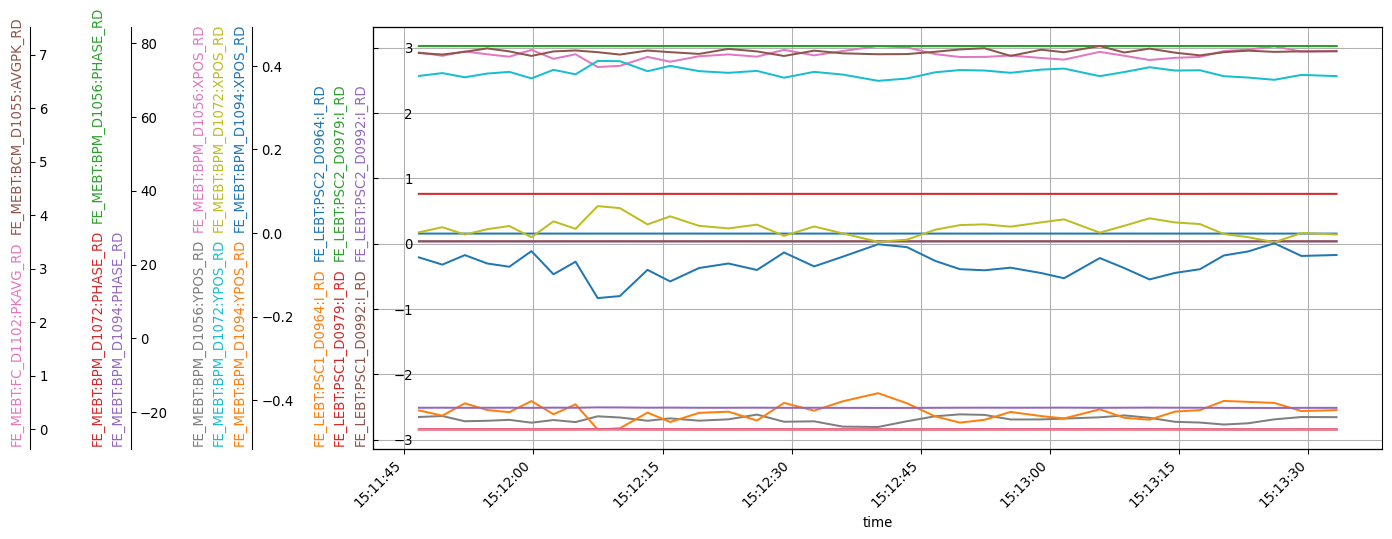

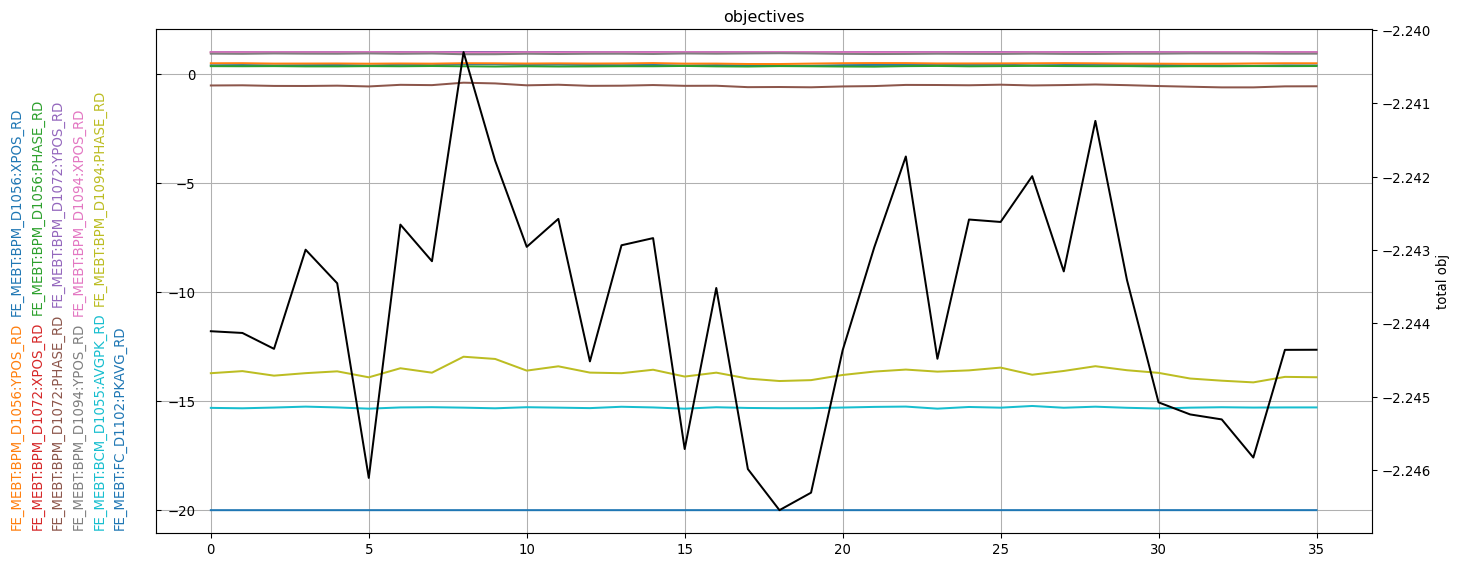

In [18]:
ctrBO.init(n_init_budget)
ctrBO.optimize_global(n_global_opt_budget, beta_scheduler='auto')
ctrBO.optimize_local (n_local_opt_budget , beta_scheduler='auto')
ctrBO.fine_tune(n_finetune_budget)
ctrBO.finalize()
for f in ctrBO.plot_callbacks:
    f.close()

### additional optimization

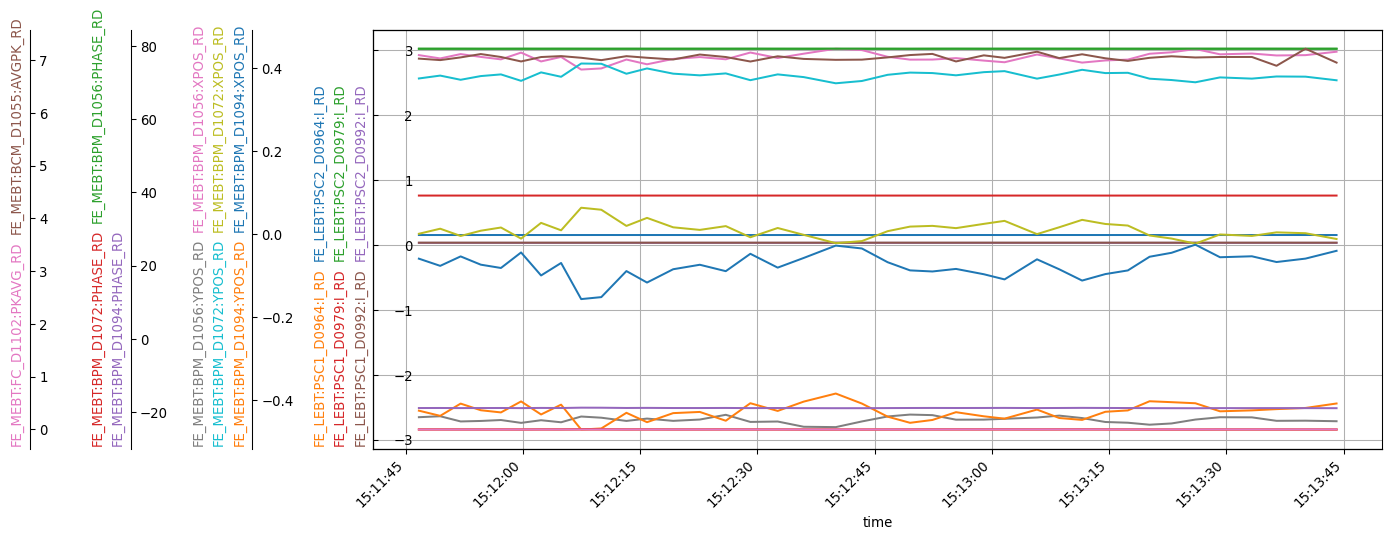

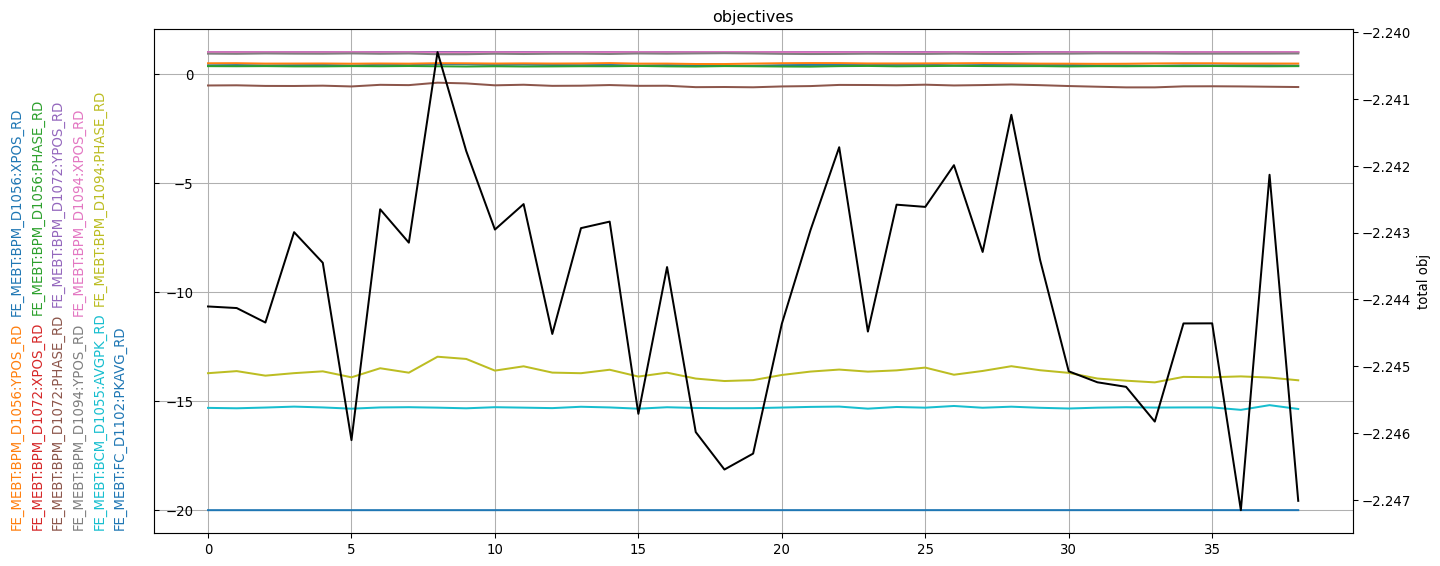

In [19]:
##== uncomment one (ore more) of the followings to optimize further
# ctrBO.optimize_global(niter=10, beta_scheduler='auto')
# ctrBO.optimize_local (niter=2, beta_scheduler='auto')

##== uncomment the followings too if any of above is uncommented
# ctrBO.fine_tune(niter=1)
# ctrBO.finalize()
# for f in ctrBO.plot_callbacks:
#     f.close()

### plot accumulated best objectives

<AxesSubplot: xlabel='evaluation budget', ylabel='best objective'>

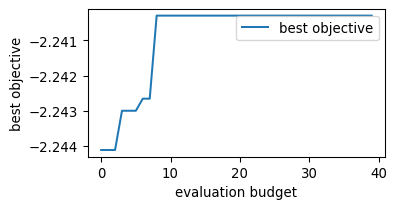

In [20]:
fig,ax = plt.subplots(figsize=(4,2),dpi=96)
ctrBO.bo.plot_obj_history(ax=ax, plot_best_only=True)

### set to best solution 

In [21]:
x_best,y_best_old = ctrBO.bo.best_sofar()
y_best_new = obj(x_best)
print(f'x_best: {x_best}')
print(f'y_best_old: {y_best_old[0]}')
print(f'y_best_new: {y_best_new}')   # check if best solution objective value is consistent

x_best: [-0.45922149 -2.81939374  4.39616008 -1.08872368 -1.24179441 -2.86745029]
y_best_old: -2.240298966743813
y_best_new: -2.2468754687728953


In [22]:
obj.save(fname=os.path.join('/files/shared/ap/jupyter-notebook/data/log/',fname))

machineIO is in test mode. skip saving data


# Visualize Surrogate model

starting projection plot...
[████████████████████████████████████████] 100%/100%

starting projection plot...
[████████████████████████████████████████] 100%/100%

starting projection plot...
[████████████████████████████████████████] 100%/100%



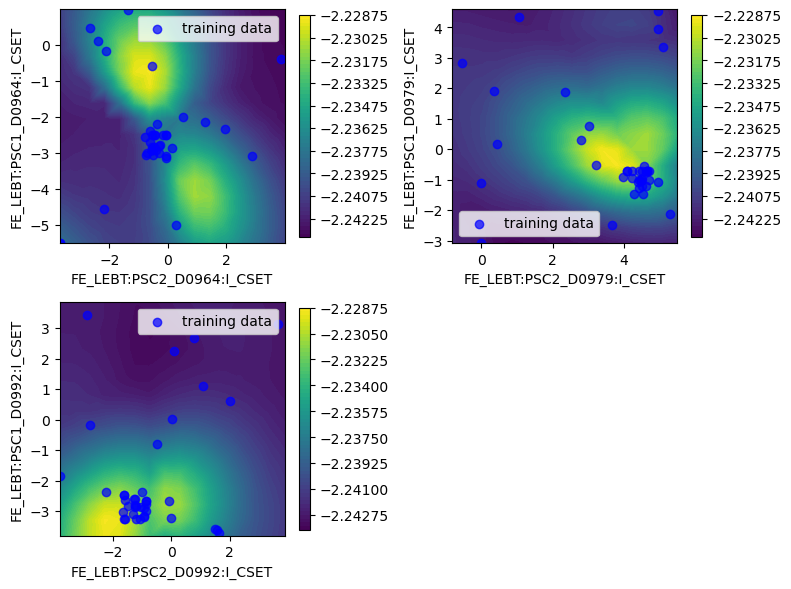

In [23]:
# plot surrogate mean model of the last epoch. Can take long time for decision dim >= 4
bo = ctrBO.bo
from math import ceil
nplot = int(0.5*len(obj.decision_CSETs))
nrow = ceil(0.5*nplot)
fig,ax = plt.subplots(nrow,2,figsize=(8,3*nrow))
for i in range(nrow):
    for j in range(2):
        n = 2*i+j
        if nrow>1:
            ax_ = ax[i,j]
        else:
            ax_ = ax[j]
        if n >= nplot:
            ax_.set_visible(False)
            break
        bo.plot_model_2D_projection(project_maximum=True,
                                    dim_xaxis = 2*n,
                                    dim_yaxis = 2*n+1,
                                    grid_ponits_each_dim = 16,
                                    fig=fig,ax=ax_);
        ax_.set_xlabel(obj.decision_CSETs[2*n  ])
        ax_.set_ylabel(obj.decision_CSETs[2*n+1])
        ax_.legend()
fig.tight_layout()